In [198]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../helper-files')))

from prompting import prompting
from get_task_embeddings import get_task_embeddings
import pandas as pd
import asyncio
import re
import numpy as np
from decimal import Decimal
from llms import gemini
from llms import chatGPT
from sklearn.metrics.pairwise import cosine_similarity
import json
import time

prompting_class = prompting()
prompting_class.get()

x_chat = chatGPT()
x_gemini = gemini()


/Users/juliasusser/Desktop/startup-gov-ai-research/src/over-time


In [199]:
df = pd.read_csv("../../output/data/retail-data.csv",index_col=0)
# df = df[df['industries'].str.contains(r'\(AI\)', na=False)]
df = df.drop_duplicates(subset=['organization name'], keep='first')
# df = df.iloc[-30:]


13159

In [200]:
def read_prompt(file):
    file_path = f"../prompts/{file}.txt"
    with open(file_path, 'r') as file:
        return file.read()
    
parsed_description_prompt = read_prompt("parse_description")
examples_prompt = read_prompt("examples")

In [201]:
examples_prompt

"Imagine you're explaining the product from $company to someone unfamiliar with it. Provide 3 concise examples of how this product could be used in a real-world scenario. Keep the descriptions general and avoid mentioning the company name.\n\nFor each example, describe:\n+ Context: description of when a person would use the tool\n+ Job Title and Task that the tool replaces\n    - Job Title should be broad and not based on specific context!\n    - Task should not use specific details from the context, just the general work activity\n    - Do not hallucinate a job activity that does not correlate with the example!\n    **Here are 10 Example Job Titles and Tasks**\n    ________________\n    Job Title: Engineering teachers, postsecondary\n    Task: Supervise undergraduate or graduate teaching, internship, and research work.\n    \n    Job Title: Instructional coordinators\n    Task: Adapt instructional content or delivery methods for different levels or types of learners.\n    \n    Job Ti

In [202]:
cols = ["parsed_description", "parsed_description_conf_interval", "parsed_description_conf_interval_reasoning", "Tasks/Jobs","Industry","Customers"]  
args = [["company","organization name"],["website","website"], ["description","description_all"]]

async def main(df):
    df = await prompting_class.iterate(df, parsed_description_prompt, args, "parsed_description_llm")
    # df.to_csv('../../output/df_with_parsed_description.csv', index=False)
    return df

df = asyncio.run(main(df))




******************************
Processing 4274: Purpose-Built Trade
******************************
Processing 3935: T-Shirt Tycoon Solutions
******************************
Processing 3936: bloom daily planners
******************************
Processing 3937: Artisan Mobile
******************************
Processing 3938: FirstSpear
******************************
Processing 3939: Rx 'N Go
******************************
Processing 3940: DL Wholesale
******************************
Processing 3941: Boomers Forever Young
******************************
Processing 3942: Watershed Distillery
******************************
Processing 3943: 6 Pack Bags


KeyboardInterrupt: 

In [ ]:
def extract_data(text):
    if pd.isnull(text): return {}
    text = re.sub(r'\s+', ' ', text)  
    text = text.replace("_", "").replace("*", "").replace("#", "")
    text = re.sub(r'\s?\([^)]*\)', '', text)
    pattern = r".*?Tasks/Jobs:\s*(.*?)\s*Industry:\s*(.*?)\s*Customers:\s*(.*?)\s*Confidence Interval:\s*(.*?)\s*Reasoning:\s*(.*)"
    match = re.search(pattern, text, re.DOTALL)
    
    if match:
        tasks_jobs = match.group(1).strip()
        industry = match.group(2).strip()
        customers = match.group(3).strip()
        confidence_interval = match.group(4).strip()
        reasoning = match.group(5).strip()
        
        result = {
            "parsed_description": 
            "Tasks/Jobs: " + tasks_jobs + "\n" + "Industry: " + industry + "\n" + "Customers: "+ customers,
            "Tasks/Jobs": tasks_jobs,
            "Industry": industry,
            "Customers": customers,
            "parsed_description_conf_interval": confidence_interval,
            "parsed_description_conf_interval_reasoning": reasoning
        }
        
        return result
    else:
        print(text)
        print("FAILURE TO MATCH")
        return {}
        
for col in cols:
    if col in list(df.columns): df=df.drop(columns=[col])
        
results_df = pd.DataFrame(list(df.apply(lambda x: extract_data(x["parsed_description_llm"]),axis=1)))
df = pd.concat([df, results_df],axis=1)


In [ ]:
df = df.dropna(subset=["parsed_description"],axis=0)
df = df.drop_duplicates(subset=['organization name'], keep='first')
df = df.reset_index(drop=True)
len(df)

30

In [ ]:
df.to_csv('../../output/df_with_parsed_description.csv', index=False)

In [ ]:
cols = [col for i in range(1,4) for col in [f"Example{i}",f"Example_Task{i}",f"Example_Description{i}",f"Example_Job_Title{i}",f"situation{i}_conf_interval",f"situation{i}_conf_interval_reasoning"]]
args = [["company","organization name"],["website","website"], ["description","description_all"], ["parsed_description","parsed_description"]]


async def main(df):
    df = await prompting_class.iterate(df, examples_prompt, args, "examples_llm")
    # df.to_csv('../../output/df_with_examples.csv', index=False)
    return df

df = asyncio.run(main(df))


******************************
Processing 0: Vantage Discovery
******************************
Processing 1: AI Product Plaza
******************************
Processing 2: Konnect.io
******************************
Processing 3: Nectar AI
******************************
Processing 4: OASIX
******************************
Processing 5: Beneree
******************************
Processing 6: Feetura
******************************
Processing 7: Rivin
******************************
Processing 8: Openmart
******************************
Processing 9: AcquireAI
******************************
Processing 10: AskShop.ai
******************************
Processing 11: TO Ventures
******************************
Processing 12: inPlace
******************************
Processing 13: Nextstay
******************************
Processing 14: visualAI retail solutions, Inc.
******************************
Processing 15: Piclist
******************************
Processing 16: Vengo AI
******************************
Proce

In [ ]:

def extract_data(text):
    if pd.isnull(text): return {}
    # Normalize the text to ensure consistent whitespace and remove unwanted characters.
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("*", "").replace("/10", "").replace("_", "").replace("#", "").replace("- ","")
    text = re.sub(r'\(.*?\)', '', text)
    vals = {}
    i = 1
    while i <=3:
        # Regex pattern adjusted to handle fractions in confidence intervals like '9/10'
        pattern = rf"""
        Context\s+{i}:\s+(.*?)\s+
        Job Title\s+{i}:\s+(.*?)\s+
        Task\s+{i}:\s+(.*?)\s+
        Confidence\s+Interval\s+{i}:\s+(\d+(?:/\d+)?)\s+
        Reasoning\s+{i}:\s+(.*?)(?=\s*Context\s+{i + 1}:|$)"""
        pattern = pattern.replace("        ","").replace("\n","")
        match = re.search(pattern, text, re.DOTALL)
        if not match:
            print(text+"\n\n")
            print(f"No matches found for Example {i}")  # Debug if no examples are found
            return {}
            break

        example_text, job_title, task, confidence_interval, reasoning = match.groups()
        description = job_title + " that " + task.lower()
        example_key = f"Example{i}"
        vals[example_key] = example_text.strip()
        vals[f"Example_Task{i}"] = task.strip()
        vals[f"Example_Job_Title{i}"] = job_title.strip()
        vals[f"Example_Description{i}"] = description.strip()
        vals[f"situation{i}_conf_interval"] = confidence_interval.strip()
        vals[f"situation{i}_conf_interval_reasoning"] = reasoning.strip()

        i += 1  # Prepare to search for the next example
    return vals

for col in cols:
    if col in list(df.columns): df=df.drop(columns=[col])

results_df = pd.DataFrame(list(df.apply(lambda x: extract_data(x["examples_llm"]),axis=1)))
df = pd.concat([df, results_df],axis=1)


In [ ]:
df.to_csv('../../output/df_with_examples.csv', index=False)

In [ ]:
df.columns

Index(['organization name', 'founded date', 'number of employees',
       'industries', 'full description', 'headquarters location',
       'description', 'website', 'description_all', 'parsed_description_llm',
       'parsed_description', 'Tasks/Jobs', 'Industry', 'Customers',
       'parsed_description_conf_interval',
       'parsed_description_conf_interval_reasoning', 'examples_llm',
       'Example1', 'Example_Task1', 'Example_Job_Title1',
       'Example_Description1', 'situation1_conf_interval',
       'situation1_conf_interval_reasoning', 'Example2', 'Example_Task2',
       'Example_Job_Title2', 'Example_Description2',
       'situation2_conf_interval', 'situation2_conf_interval_reasoning',
       'Example3', 'Example_Task3', 'Example_Job_Title3',
       'Example_Description3', 'situation3_conf_interval',
       'situation3_conf_interval_reasoning'],
      dtype='object')

In [ ]:
for i in range(1,3):
    df[f"Example_Description{i}"] = df[f"Example{i}"] + df[f"Example_Description{i}"]

In [ ]:
df[f"Example_Description{i}"][0]

"A news website utilizes Vantage Discovery to enable users to search for articles based on a natural language query, understanding the user's intent and context rather than relying on keywords. This allows users to find relevant articles even if they don't know the exact keywords to use, improving the searchability of content.Content Manager that manage and optimize content to improve user engagement and search visibility."

In [ ]:


job_cols = [[f"Example_Description{i}",f"Example_Job_Title{i}"] for i in range(1,4)]
for job in job_cols:
    for col in job:
        df = x_chat.run_batch_embeddings(df,col)

df.to_csv('../../output/df_with_examples_embeddings.csv', index=False)


Processing final batch 0 to 30
Processing final batch 0 to 30
Processing final batch 0 to 30
Processing final batch 0 to 30
Processing final batch 0 to 30
Processing final batch 0 to 30


In [ ]:
task_embeddings, title_embeddings, df_exp = get_task_embeddings().get()

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x10378e700>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


In [ ]:

results = []
# results = list(pd.read_csv("../output/onet_df.csv").values)

for index, row in list(df.iterrows())[0:]:
    print("***********************")
    print(f"Processing {index}")
    name = row["organization name"]
    print(name)
    print(row["industries"])
    print(row["description_all"])
        
    job_results = []
    for i in range(1): 
        example = row[f"Example{i+1}"]
        description = row[f'Example_Description{i+1}']
        job_title = row[f'Example_Job_Title{i+1}']
        print(f"\nProcessing Example: {example} \nJob: {description}\n")

        job_embedding = np.array(row[f'Example_Description{i+1}_embedding']).reshape(1,-1)
        job_title_embedding = np.array(row[f'Example_Job_Title{i+1}_embedding']).reshape(1,-1)
        cosine_sim = cosine_similarity(job_embedding, task_embeddings)
        
        top3 = sorted(zip(cosine_sim[0], df_exp[['title', 'Task', 'description','title_embedding']].values), reverse=True)[:3]
        for cosine_sim_job, onet in top3:
            print(cosine_sim_job)
            onet_title_embedding = np.array([onet[3]])
            cosine_sim_title =cosine_similarity(job_title_embedding, onet_title_embedding)[0][0]
            print(f"{onet[2]} \nCosine Similarity: {cosine_sim_job}, Person Cosine Similarity: {cosine_sim_title}")
            results.append([name,example,row[f"situation{i+1}_conf_interval"], row[f"situation{i+1}_conf_interval_reasoning"],job_title,onet[0],onet[1],job_title, cosine_sim_job,cosine_sim_title])
 

    if index % 50 == 0:
        print("**Saving Results**\n\n")
        onet_df = pd.DataFrame(results, columns=["organization_name","example","situation_conf_interval", "situation_conf_interval_reasoning","job","onet_title","onet_task","example_job_title","task_similarity", "job_title_similarity"])
        onet_df.situation_conf_interval = onet_df.situation_conf_interval.astype("float")
        onet_df.to_csv("../../output/onet_df.csv", index=False)
        time.sleep(10)
        
    print("***********************\n\n")


onet_df = pd.DataFrame(results, columns=["organization_name","example","situation_conf_interval", "situation_conf_interval_reasoning","job","onet_title","onet_task","example_job_title","task_similarity", "job_title_similarity"])
onet_df.situation_conf_interval = onet_df.situation_conf_interval.astype("float")
onet_df.to_csv("../../output/onet_df.csv", index=False)

***********************
Processing 0
Vantage Discovery
Artificial Intelligence (AI), Content Discovery, Personalization, SaaS, Semantic Search
Vantage Discovery is a generative AI-powered SaaS search and content discovery platform that provides personalized shopping recommendations. Vantage Discovery is an engine for harnessing the power of generative AI embeddings to deliver astoundingly insightful search results,  a platform for enabling new experiences for discovering and contextualizing content and products,  and a service for implementing production-ready solutions in hours,  not weeks. Apps can switch from keyword-based to semantic search with the Vantage API,  which understands the user's meaning,  intent,  and context.

Processing Example: An e-commerce website for handmade crafts uses Vantage Discovery to provide shoppers with personalized recommendations based on their browsing history and purchase preferences. The platform analyzes the user's past interactions and suggests s

In [ ]:
len(pre[pre.automation_rating > 30])/len(pre)

0.3624161073825503

In [ ]:
len(post[post.automation_rating > 30])/len(post)

0.46621621621621623

In [ ]:
pre[pre.automation_rating == 1].iloc[0].values

array(['TYR Tactical', '2010-01-01', '101-250',
       'Apparel,E-Commerce,Military,Wearables,—,Peoria', 'Arizona',
       'United States',
       'TYR Tactical provides a wide range of military gear such as shields, armor plates, vests, tactical apparel, bags and weapon accessories.',
       'www.tyrtactical.com/',
       'TYR Tactical provides a wide range of military gear such as shields, armor plates, vests, tactical apparel, bags and weapon accessories. Arizona',
       "Description: TYR Tactical is a leading provider of high-performance tactical gear and apparel, specializing in lightweight, durable equipment designed for military and law enforcement professionals. Their products include advanced body armor, tactical vests, shields, and a wide range of accessories to enhance performance and safety in demanding environments.\n\nConfidence Interval: 8\n\nReasoning:  This description is based on the information available on their website, emphasizing their focus on military and law 

In [ ]:
df.iloc[0]

organization name                                                                          Jetlore
founded date                                                                            2011-01-01
number of employees                                                                          11-50
industries                                       Artificial Intelligence (AI),Big Data,E-Commer...
full description                                                                        California
headquarters location                                                                United States
description                                      Jetlore offers an AI-powered prediction platfo...
website                                                                            www.jetlore.com
description_all                                  Jetlore offers an AI-powered prediction platfo...
generated_description_llm                        Description (in two sentences): Jetlore levera...
generated_

In [ ]:

# words = ["task", " AI ", "automate", "workflow", "streamline","productivity", "generate", "data"]
# pattern = '|'.join(words)
# df = df[df.generated_description.str.contains(pattern, case=False, na=False)]

In [ ]:
# Load and process the data
df = pd.read_csv("../output/df_with_filter.csv")
df['founded date'] = pd.to_datetime(df['founded date'])
df['year'] = df['founded date'].dt.year
df["AI startup"] = df['industries'].str.contains(r'\(AI\)', na=False)
len(df)

13131

In [ ]:
grouped = df.groupby('year').agg({'automation_rating':'mean','organization name':'count','AI startup':'sum'}).reset_index().rename({'organization name':'total number of startups','AI startup':'total number of AI startups'},axis=1)
greater = df[df.automation_rating > 60].groupby('year').agg({'organization name':'count'}).reset_index().rename({'organization name':'greater'},axis=1)
grouped = grouped.merge(greater, on="year")
grouped["percent AI startups"] = grouped["total number of AI startups"]/grouped["total number of startups"]
grouped["percent of startups with rating above 70"] = grouped["greater"]/grouped["total number of startups"]
grouped = grouped.drop(columns=["greater"])
grouped

,year,automation_rating,total number of startups,total number of AI startups,percent AI startups,percent of startups with rating above 70
0,2010,23.045596,965,2,0.002073,0.095337
1,2011,25.663655,996,17,0.017068,0.111446
2,2012,26.236948,996,9,0.009036,0.142570
3,2013,26.156784,995,24,0.024121,0.139698
4,2014,27.043129,997,25,0.025075,0.134403
5,2015,26.671026,994,26,0.026157,0.150905
6,2016,27.864594,997,40,0.040120,0.159478
7,2017,27.824597,992,37,0.037298,0.156250
8,2018,27.751766,991,33,0.033300,0.163471
9,2019,27.400609,986,35,0.035497,0.154158


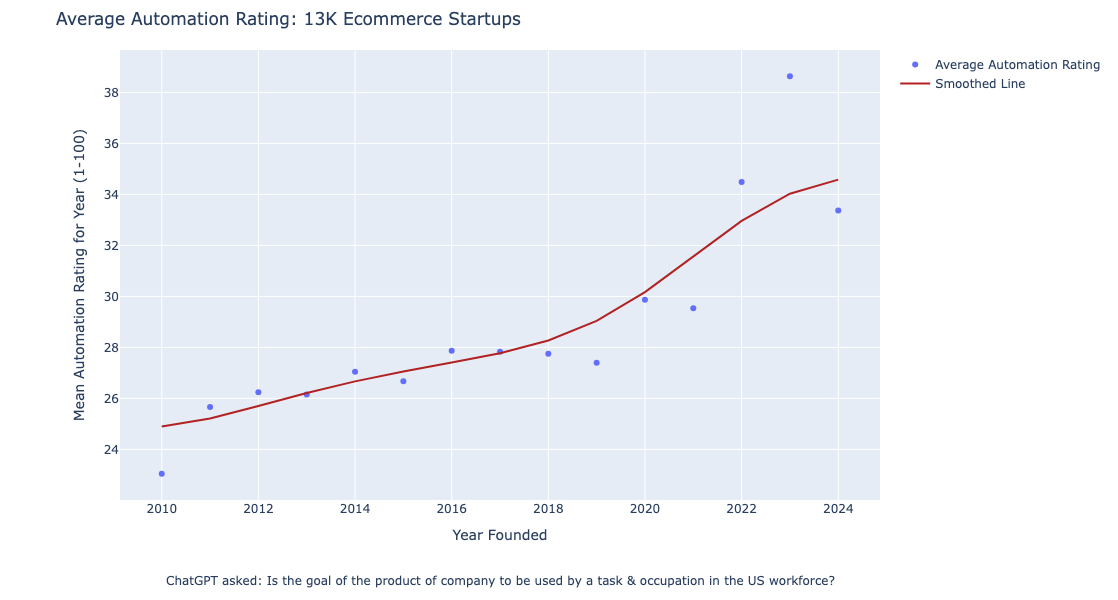

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import plotly.io as pio

# Apply Gaussian smoothing
smoothed_ratings = gaussian_filter1d(grouped['automation_rating'], sigma=2)

# Create the figure
fig = go.Figure()

# Add the scatter plot
fig.add_trace(go.Scatter(
    x=grouped["year"], 
    y=grouped["automation_rating"], 
    mode='markers', 
    name='Average Automation Rating'
))

# Add the smooth line
fig.add_trace(go.Scatter(
    x=grouped["year"], 
    y=smoothed_ratings, 
    mode='lines', 
    name='Smoothed Line',
    line=dict(color='firebrick', width=2)
))

# Update layout with titles and dimensions
fig.update_layout(
    title="Average Automation Rating: 13K Ecommerce Startups",
    xaxis_title="Year Founded",
    yaxis_title="Mean Automation Rating for Year (1-100)",
    width=800,
    height=600,
    margin=dict(l=120, r=120, t=50, b=100) 
)

# Add the annotation for the caption
fig.add_annotation(
    text="ChatGPT asked: Is the goal of the product of company to be used by a task & occupation in the US workforce?",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,
    showarrow=False,
    font=dict(size=12),
    xanchor='center'
)

# Show the plot
fig.show()
pio.write_image(fig, '../output/automation_rating_over_years.png')

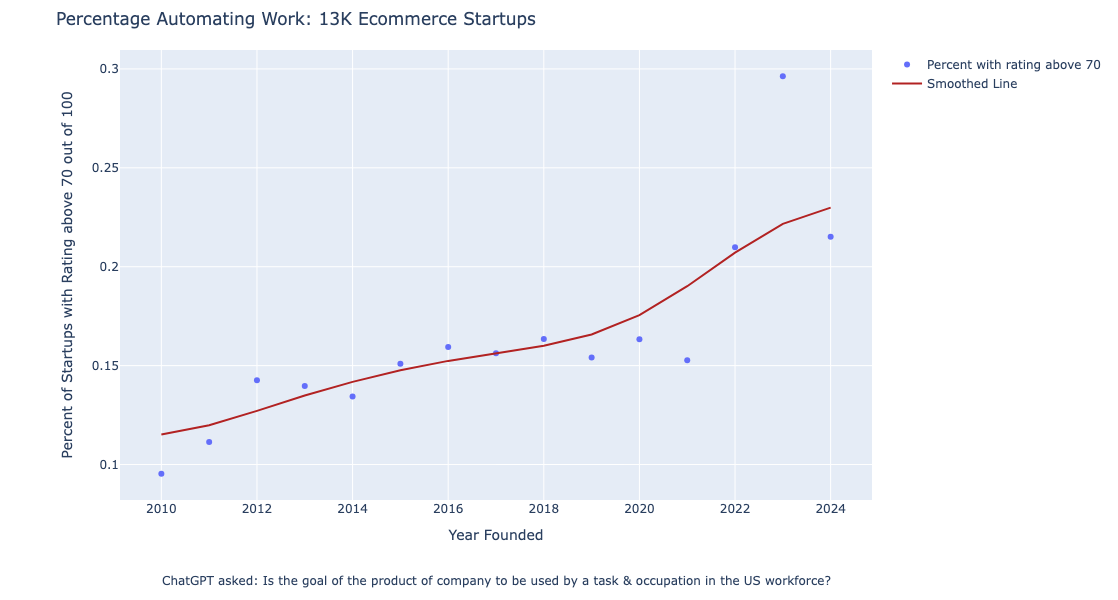

In [ ]:


# Apply Gaussian smoothing
smoothed_ratings = gaussian_filter1d(grouped["percent of startups with rating above 70"], sigma=2)

# Create the figure
fig = go.Figure()

# Add the scatter plot
fig.add_trace(go.Scatter(
    x=grouped["year"], 
    y=grouped["percent of startups with rating above 70"], 
    mode='markers', 
    name='Percent with rating above 70'
))

# Add the smooth line
fig.add_trace(go.Scatter(
    x=grouped["year"], 
    y=smoothed_ratings, 
    mode='lines', 
    name='Smoothed Line',
    line=dict(color='firebrick', width=2)
))

# Update layout with titles and dimensions
fig.update_layout(
    title="Percentage Automating Work: 13K Ecommerce Startups",
    xaxis_title="Year Founded",
    yaxis_title="Percent of Startups with Rating above 70 out of 100",
    width=800,
    height=600,
    margin=dict(l=120, r=120, t=50, b=100) 
)

# Add the annotation for the caption
fig.add_annotation(
    text="ChatGPT asked: Is the goal of the product of company to be used by a task & occupation in the US workforce?",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,
    showarrow=False,
    font=dict(size=12),
    xanchor='center'
)

# Show the plot
fig.show()
pio.write_image(fig, '../output/percentage_automation_rating_over_years.png')

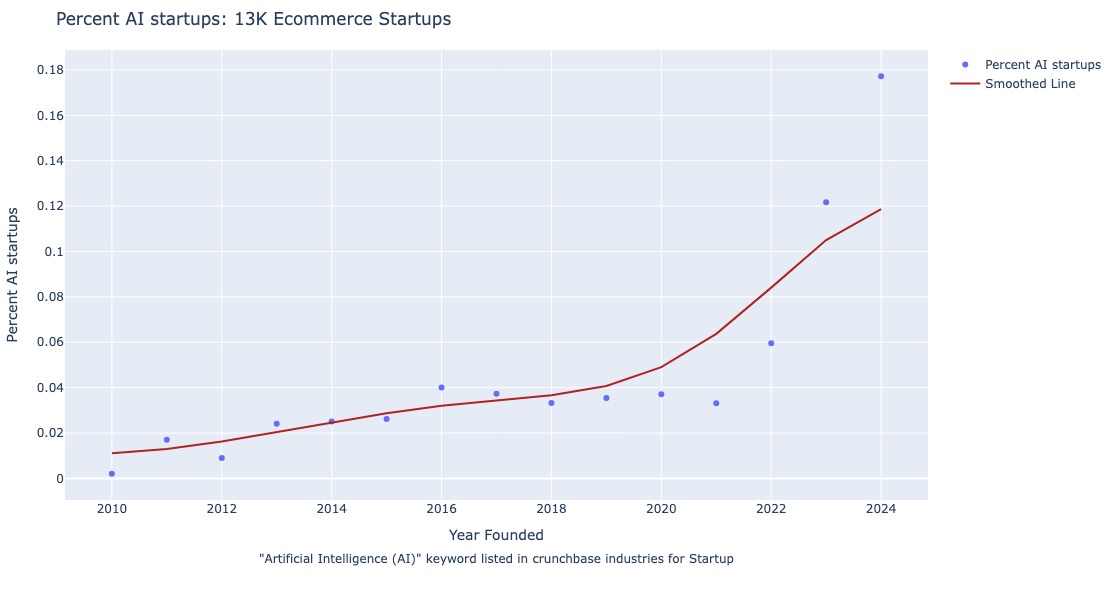

In [ ]:


# Apply Gaussian smoothing
smoothed_ratings = gaussian_filter1d(grouped['percent AI startups'], sigma=2)

# Create the figure
fig = go.Figure()

# Add the scatter plot
fig.add_trace(go.Scatter(
    x=grouped["year"], 
    y=grouped["percent AI startups"], 
    mode='markers',
    name='Percent AI startups'
))

# Add the smooth line
fig.add_trace(go.Scatter(
    x=grouped["year"], 
    y=smoothed_ratings, 
    mode='lines', 
    name='Smoothed Line',
    line=dict(color='firebrick', width=2)
))

# Update layout with titles and dimensions
fig.update_layout(
    title="Percent AI startups: 13K Ecommerce Startups",
    xaxis_title="Year Founded",
    yaxis_title="Percent AI startups",
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=50, b=100) 
)

# Add the annotation for the caption
fig.add_annotation(
    text='"Artificial Intelligence (AI)" keyword listed in crunchbase industries for Startup',
    xref="paper", yref="paper",
    x=0.5, y=-0.15,
    showarrow=False,
    font=dict(size=12),
    xanchor='center'
)

# Show the plot
fig.show()
pio.write_image(fig, '../output/percentage_ai_startups_over_years.png')